### Dependencies

In [1]:
%matplotlib notebook
import  matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import time

from modules.startup import MyFuncs
Abs = MyFuncs.Absorbance

from ipywidgets import interact
import ipywidgets as widgets
from ipywidgets import interactive, Layout, HBox,VBox, Label
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

### Database class definition

In [2]:
class MyDB():
    
    np = __import__('numpy')
    os = __import__('os')
    base64 = __import__('base64')
    hashlib = __import__('hashlib')
    unicodedata = __import__('unicodedata')
    
    
    def __init__(self, base_dir = '.'):
        self.base_dir = base_dir
        self.data = {}
        self.update()
        self.tags = []
        self.selected_tags = []
        #self.list_tags()
        self.spectrometers = self.np.load('detectors.npz', mmap_mode='r')
        self.check = None
        self.ViewPort = None
        
            
    def update(self):
        for root, directories, filenames in self.os.walk(self.base_dir):
            if '.debris' in root:
                pass
            else:
                for filename in filenames: 
                    if filename[-3:]=='npz' and filename not in self.data.keys():
                        self.data[self.base64.b64encode(self.hashlib.md5(str.encode(filename)).digest()).decode("utf-8") ]=  self.os.path.join(root,filename)
                    else:
                        pass
                    
                    
    def normalize_caseless(self, text):
        if type(text) in [str]:
            return self.unicodedata.normalize("NFKD", text.casefold())

        elif type(text)==list:
            return [self.unicodedata.normalize("NFKD", textitem.casefold()) for textitem in text]
        else:
            raise TypeError('Wrong input type for conversion. Only string or list are allowed.')

            
    def list_experiments(self):
        
        for id_ in self.data.keys():
            with self.np.load(self.data[id_], mmap_mode='r') as dataset:
                is_sensor_data=False
                if 'tags' in dataset.keys():
                    for tag in dataset['tags']:
                        text = str(tag)
                        if self.normalize_caseless('ref') in self.normalize_caseless(text):
                            is_sensor_data=True
                        elif self.normalize_caseless('biofilm') in self.normalize_caseless(text):
                            is_sensor_data=True
                        else:
                            pass                            
                    if is_sensor_data:
                        self.tags.append(dataset['tags'][0])
                else:
                    pass
        self.tags = set(self.tags)
        self.tags = sorted(list(self.tags))        
        
        selected = self.interact_tags()
        def select(tag):            
            if tag in self.selected_tags:
                pass
            else:
                self.selected_tags.append(tag)
                selected.children[0].options = self.selected_tags[::-1]
                
        options=self.tags+['']
        selector = widgets.Dropdown(
            options=options,
            value= options[-1],
#             rows=7,
            description='add tags for Query:',
            disabled=False
        )
        return widgets.HBox([interactive(select, tag=selector), selected], description=('left', 'right'))
    
    
        
    def list_tags(self):
        
        for id_ in self.data.keys():
            with self.np.load(self.data[id_], mmap_mode='r') as dataset:
                if 'tags' in dataset.keys():
                    for tag in dataset['tags']:
                        self.tags.append(tag)
                else:
                    pass
        self.tags = set(self.tags)
        self.tags = sorted(list(self.tags))        
        
        selected = self.interact_tags()
        
        def select(tag):            
            if tag in self.selected_tags:
                pass
            else:
                self.selected_tags.append(tag)
                selected.children[0].options = self.selected_tags[::-1]
                
        options=self.tags+['']
        selector = widgets.Dropdown(
            options=options,
            value= options[-1],
#             rows=10,
            description='add tags for Query:',
            disabled=False
        )
        return widgets.HBox([interactive(select, tag=selector), selected], description=('left', 'right'))
  

    def interact_tags(self):
        
        def uncheck_tag(tag): 
            if tag =='':
                pass
            else:
                self.selected_tags.remove(tag) 
                selected.children[0].options=self.selected_tags[::-1]
        
        options = self.selected_tags+['']
        selector = widgets.Dropdown(
            options=options,
            value= options[-1],
#             rows=5,
            description='remove tags from Query:',
            disabled=False
        ) 
        selected = interactive(uncheck_tag, tag = selector)
        return selected


### Query class definition

In [3]:
class MyQuery():
    
    np = __import__('numpy')
    
    def __init__(self, database, *keywords, key='tags'):
        self.database = database
        selected = self.database.selected_tags
        if '' in selected:
            selected.remove('')
        self.keywords = keywords +tuple(selected)
        self.key = key
        self.result = self.query(*self.keywords, key=self.key)
        self.t0 = None
        
    def query(self, *keywords, key='tags'):
        query = []
        for id_ in self.database.data.keys():
            with self.np.load(self.database.data[id_], mmap_mode='r') as dataset:
                if key in dataset.keys():
                    is_there = []
                    for arg in keywords: 
                        if np.ndim(dataset[key])==0:
                            if arg in dataset[key]:
                                is_there.append(True)
                        else:
                            for tag in dataset[key]:
                                if arg in tag:
                                    is_there.append(True)
                    if len(is_there)==len(keywords):
                        query.append(self.database.data[id_])  
        if len(query)==1:
            query = query[0]

        return query
    
    def print_tags(self):
        if self.result==[]:
            print('No matches found.')
        else:
            for npz in self.result:
                with self.np.load(npz, mmap_mode='r') as item:
                    print(item['tags'])

    def print_keys(self):
        if self.result==[]:
            print('No matches found.')
        else:
            for npz in self.result:
                with self.np.load(npz, mmap_mode='r') as item:
                    print(item.keys())

    def select(self, *keywords):
        filtered_query = []
        for npz in self.result:
            with self.np.load(npz, mmap_mode='r') as result:
                for arg in keywords:
                    is_there=[]
                    for key in result.keys():
                        if arg in result[key]:
                            is_there.append(True)
                if len(is_there)==len(keywords):
                        filtered_query.append(result)  
        if len(filtered_query)==1:
            filtered_query = filtered_query[0]
        return filtered_query
    
    
    def sort(self, key, index = None, result = None, getter_func=None):
        if not result:
            result=self.result
            
        test = []
        for npz in result:
            with self.np.load(npz, mmap_mode='r') as item:
                try:            
                    item[key]
                    test.append(npz)
                except KeyError:
                    pass
        result = test  
        
        def getKey(npz):
            if getter_func:
                with self.np.load(npz, mmap_mode='r') as item:
                    return getter_func(item[key])
            elif index:
                
                with self.np.load(npz, mmap_mode='r') as item:
                    return item[key][index]
            else:
                with self.np.load(npz, mmap_mode='r') as item:
                    return item[key]
            
        query = sorted(result, key=getKey)
        self.result = query

## *Experimental Data*

## Initialise Database and set tags for Query

In [4]:
db = MyDB()
# db.list_tags()
db.list_experiments()

A Jupyter Widget

## Create (quasi) tidy pandas dataset from Query-result##
For the following definition we assume the ideal case in which both LED light sources are equally affected by external factors e. g. peaks in alimentation voltage or temperature and that deposition of organic or inorganic material on the reference waveguide has a negligible influence on the transmitted light intensity and spectrum due to the high refractive index contrast to the aqueous medium (-> **do we need to make sure and encapsulate?**). 

In [5]:
def create_tidy_dataset(mode='a'):
    
    """
        variables = ['time [s]', 'temperature [oC]', 'clorine content [ppm]']
        observations = ['A (λ)']
        constants = ['wavelengths']
        
    """    
    readouts = {'biofilm': MyQuery(db, db.selected_experiment, 'biofilm'),
                'reference': MyQuery(db, db.selected_experiment, 'ref')}
    for key in readouts.keys():
        readouts[key].sort('time', index=1)
    time = []
    if mode=='a':
        spectra = []
    elif mode=='i':
        spectra = {'biofilm':[],'ref':[]}
    for i, npz in enumerate(readouts['biofilm'].result):
        
        with np.load(npz, mmap_mode='r') as readout:
            time.append(readout['time'][1])
            wavelengths = db.spectrometers[readout['detector'].item()] 
            with np.load(readouts['reference'].result[i], mmap_mode='r') as reference:
                
                if mode=='a':
                    S_n = Abs(readout['intensities'], reference['intensities'])
                    spectra.append([pd.Series(S_i, index=np.round(wavelengths, 2)) for S_i in S_n])
                    
                elif mode=='i':
                    S_nb, S_nr = readout['intensities'], reference['intensities']                    
                    spectra['biofilm'].append([pd.Series(S_b, index=np.round(wavelengths, 2)) for S_b in S_nb])
                    spectra['ref'].append([pd.Series(S_r, index=np.round(wavelengths, 2)) for S_r in S_nr])
    if mode=='a':
        tidy_dataset = pd.Series(spectra, index=time)
    elif mode=='i':
        tidy_dataset = {'biofilm':pd.Series(spectra['biofilm'], index=time),
                        'reference':pd.Series(spectra['ref'], index=time)}
                    
    return tidy_dataset

df = create_tidy_dataset('i')

# SENIX#1: Pilot Plant

In [7]:
experiment_name = 'SENIX#2@CETAQUA_pilot'
# or use 
# excperiment_name = db.selected_tags[0]
df = create_tidy_dataset(experiment_name)

### Last readout###

In [8]:
def check_last_readout(experiment_name):
    data = MyQuery(db, experiment_name, 'biofilm')
    data.sort('time', index=1)
    with np.load(data.result[-1], mmap_mode='r') as last:        
        last_timestamp = last['tags'][-1]
        current_time = time.time()
        minutes_elapsed = (current_time - (last['time'][0] + last['time'][1]))/60 
        period = last['period [min]']

    if minutes_elapsed <= period:
        displayed_text = '<br>Last readout:  <br><font size="6"><b style="color:#4CC417">'+ last_timestamp +'</b></font>'
    else:
        displayed_text = '<font size="6"><b style="color:#FF0000">Readout overdue<br></b></font> Last readout:  <br><font size="6"><b>'+ last_timestamp +'</b></font>'
    return displayed_text

### Define Interactive Data Display

In [12]:
class ViewPort():

    def __init__(self, df):
        
        self.df = df   
        self.interactive_df = df        
        self.selected_time = self.interactive_df.index[-1]
        self.wavelength_range = (405.02,745.76)
        
        self.wl_range_selector = widgets.SelectionRangeSlider(
                                                        options=self.interactive_df[self.selected_time][0].index,
                                                        value = (405.02,745.76),
                                                        description=' ',
#                                                         layout=Layout(width='200%', height='50px'),
                                                        continuous_update =False,
                                                        disabled=False
                                                        )
        
#         self.time_selector = widgets.SelectionRangeSlider(
#                                                         options=range(len(df.index)),
#                                                         value = (0,len(df.index)-1),
#                                                         description='readouts',
# #                                                         layout=Layout(width='200%', height='50px'),
#                                                         continuous_update =False,
#                                                         disabled=False
#                                                         )
        self.wl_index = widgets.Dropdown(options = self.interactive_df[self.selected_time][0].index,
                                         value=540.9,
                                        disabled=False)
        self.time_units = widgets.RadioButtons(options=['min', 'h', 'days', 'weeks'],
                                               value = 'h',
                                              disabled=False)
        
        self.wl_range = HBox([Label('define wavelength range [nm]'), self.wl_range_selector])
        self.Figure = interactive(self.interact_Figure, unit = self.time_units, wl_index=self.wl_index)
#         display(HBox([Label('define wavelength range [nm]'), self.wl_range_selector]), 
#                 Figure)
        
    def interact_Figure(self, unit, wl_index):
        self.fig = plt.figure(num='Interactive Data Display', figsize=(10, 10), dpi=80)
        self.timeline = self.fig.add_subplot(212)
#         self.timeline.set_title('click on points')
        self.timeline.set_xlabel('time [h]')
        self.timeline.set_ylabel('Absorbance [A.U.]')
        
        self.Abs_plot = self.fig.add_subplot(211)
#         self.Abs_plot.set_title('Absorbance [A.U.] spectrum at time $t_0$')
        self.Abs_plot.set_xlabel('Wavelength [nm]')
        self.Abs_plot.set_ylabel('Absorbance [A.U.]')
#         self.Abs_plot.autoscale(enable=True, axis='y', tight=False)
        
        self.N = len(self.df[self.df.index[1]])            
        
        if unit=='min':
            self.timeline.clear()
            self.timeline.set_xlabel('time [min]')
            self.timeline.set_ylabel('Absorbance [A.U.]')
            self.interactive_df = pd.Series(self.df.values, index = self.df.index/60)
        if unit=='h':
            self.timeline.clear()            
            self.timeline.set_xlabel('time [h]')
            self.timeline.set_ylabel('Absorbance [A.U.]')
            self.interactive_df = pd.Series(self.df.values, index = self.df.index/60/60)
        if unit=='days':
            self.timeline.clear()
            self.timeline.set_xlabel('time [days]')
            self.timeline.set_ylabel('Absorbance [A.U.]')
            self.interactive_df = pd.Series(self.df.values, index = self.df.index/60/60/24)  
        if unit=='weeks':
            self.timeline.clear()
            self.timeline.set_xlabel('time [weeks]')
            self.timeline.set_ylabel('Absorbance [A.U.]')
            self.interactive_df = pd.Series(self.df.values, index = self.df.index/60/60/24/7)          
                
        times=self.interactive_df.index[1:]
        self.selected_time = times[-1]
        
        for n in range(self.N-1):            
            self.timeline.plot(times, [self.interactive_df[time][n][wl_index] for time in times], 
                            'o',markersize=3,
                            c='k', picker=5)
        self.timeline.plot(times, [self.interactive_df[time][self.N-1][wl_index] for time in times], 
                                'o',markersize=3,
                                c='k', picker=5,
                               label = 'Absorbance over time, $N=%i$'%self.N)
#         self.timeline.set_xdata([time/60 for time in times])
        self.ylims = self.timeline.get_ylim()
        self.timeline.plot((times[0],times[0]), self.ylims,'-.', c='0.5')
        self.timeline.legend()
        
        self.fig.canvas.mpl_connect('pick_event', self.onpick)
        self.show_A()
        self.fig.show()
        plt.tight_layout()
        

    def onpick(self, event):  

        thisline = event.artist
        self.line = thisline
        xdata = thisline.get_xdata()
        ydata = thisline.get_ydata()
        ind = event.ind
        points = tuple(zip(xdata[ind], ydata[ind]))
        self.timeline.lines[-1].remove()
        self.selected_time = points[0][0]
        self.cursor, = self.timeline.plot((points[0][0],points[0][0]), self.ylims, '-.', c='0.5')
        self.timeline.set_ylim(self.timeline.get_ylim())
        self.show_A()
        
        plt.tight_layout()
        
    def set_wavelength_range(self, wavelength_range):
        self.wavelength_range = wavelength_range
        
    def show_A(self):        
        wl1=self.wl_range_selector.value[0]
        wl2=self.wl_range_selector.value[1]
        try:
            for n in range(len(self.interactive_df[self.selected_time])):
                self.Abs_plot.lines[-1].remove()
        except IndexError:
            pass
        
#         self.Abs_plot.set_title('Absorbance [A.U.] spectrum at $t=%f$ %s' %(self.selected_time,self.time_units.value))        
        for n in range(len(self.interactive_df[self.selected_time])):
            if n==0:
                self.Abs_plot.plot(self.interactive_df[self.selected_time][n][wl1:wl2],'o', c='0.5',markersize=1.5, 
                                   label= '$t=%f$ %s' %(self.selected_time,self.time_units.value))
            else:
                self.Abs_plot.plot(self.interactive_df[self.selected_time][n][wl1:wl2], 'o',c='0.5',markersize=1.5)
                
#         self.Abs_plot.set_xlim((wl1,wl2))
#         self.Abs_plot.set_ylim((0.02,.8))
        self.Abs_plot.legend()
        self.Abs_plot.relim(visible_only=True)
        


### Refresh display

In [13]:
def refresh(b):
    data_length = len(db.data)
    db.update()
    
    if len(db.data)>data_length:
        df = create_tidy_dataset(experiment_name)        
        v.df = df
        timestamp_display.value= check_last_readout(experiment_name)
    

A Jupyter Widget

A Jupyter Widget

<IPython.core.display.Javascript object>


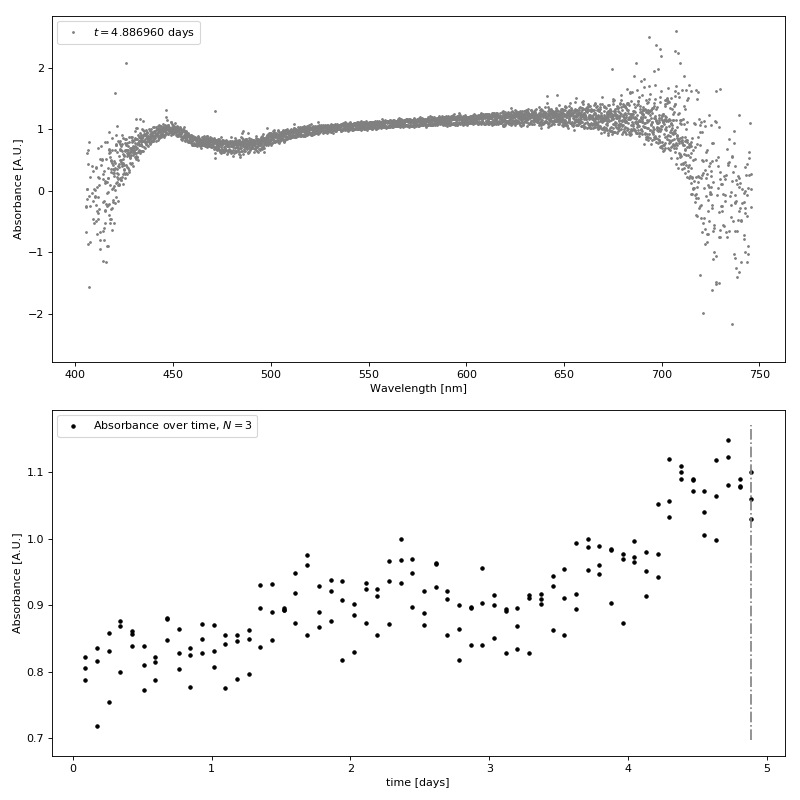

In [21]:
timestamp_display = widgets.HTML(value = check_last_readout(experiment_name))
v = ViewPort(df)
b = widgets.Button(description="Refresh",layout=Layout(width='100%', height='50px'))
b.on_click(refresh)

display(b)
display( VBox([timestamp_display,
                   v.wl_range,
                   v.Figure, 
                    ])
             )
v.fig


## Plot intensities

<IPython.core.display.Javascript object>


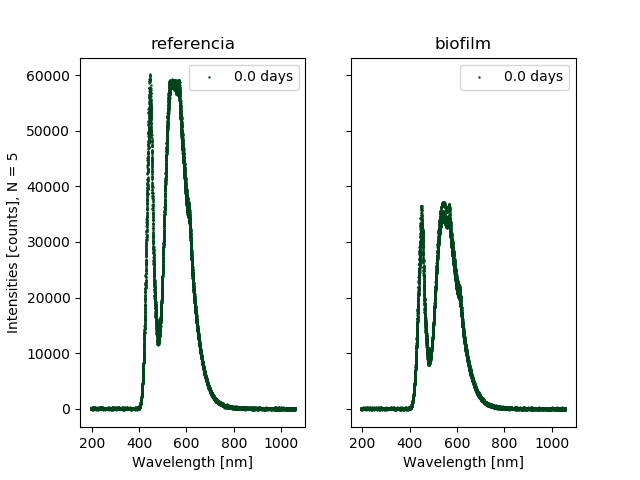

A Jupyter Widget

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True)
axes = (ax1, ax2)
    
def plot_I(index_range):
    
    for i, dataset in enumerate(readouts):
        axes[i].clear()
        color = 0
        
        for result in dataset.result[index_range[0]:index_range[1]]:    
            label = str(round(result['time'][1]/60/60/24, 1))+' days'
            wavelengths = db.spectrometers[result['detector'].item()] 
            I = result['intensities']
            for spec in I[:-1]:
                axes[i].scatter(wavelengths, spec, c=cm.Greens(300), 
                 s = 0.5 )
            axes[i].scatter(wavelengths, I[-1],c=cm.Greens(300-color), 
                 s = 0.5, 
                label=label
                           )
            color+=20
        axes[i].set_title(result['tags'][1])
        axes[i].set_xlabel('Wavelength [nm]')
        axes[i].legend();
    axes[0].set_ylabel('Intensities [counts], N = '+str(result['N'].item()));
    axes[1].relim()
    axes[1].autoscale_view()
    plt.show()

options = [i for i in range(len(readouts[0].result))]
range_selector = widgets.SelectionRangeSlider(
        options=options,
        value = (0,1),
        #index=(0,len(options)-1),
        description='define range',
        continuous_update =False,
        disabled=False
        )

interactive_plot = interactive(plot_I, index_range = range_selector)
interactive_plot

In [50]:
times={}
for result in readouts[0].result:
    times[str(round(result['time'][1]/60/60, 5))+' hours'] = result['time'][1]

def select_t0(time):
    #print('Selected:', [dataset.select(times[time]) for dataset in readouts])
    #return sensor.select(time)
    for dataset in readouts:
        dataset.t0 = times[time]
    

ref_selector = widgets.Select(
    options=[time for time in times.keys()],
    value=[time for time in times.keys()][0],
    rows=3,
    description='Select t$_0$:',
    disabled=False
)

interactive(select_t0, time=ref_selector)

A Jupyter Widget

<IPython.core.display.Javascript object>


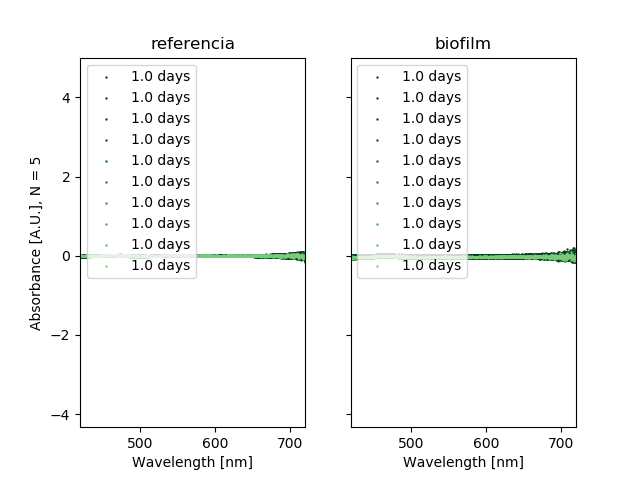

A Jupyter Widget

In [52]:

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True)
axes = (ax1, ax2)
    
def plot_A(index_range):
    
    for i, dataset in enumerate(readouts):
        axes[i].clear()
        color = 0
                
        for result in dataset.result[index_range[0]:index_range[1]]:    
            label = str(round(result['time'][1]/60/60/24, ))+' days'
            wavelengths = db.spectrometers[result['detector'].item()] 
            A = Abs(result['intensities'],dataset.select(dataset.t0)['intensities'])
            
            for spec in A[:-1]:
                axes[i].scatter(wavelengths, spec, c=cm.Greens(300), 
                 s = 0.5 )
            axes[i].scatter(wavelengths, A[-1],c=cm.Greens(300-color), 
                 s = 0.5, 
                label=label
                           )
            color+=20
        axes[i].set_title(result['tags'][1])
        axes[i].set_xlabel('Wavelength [nm]')
        axes[i].legend();
    axes[0].set_xlim((420, 720))    
    axes[0].set_ylabel('Absorbance [A.U.], N = '+str(result['N'].item()));
    axes[0].relim()
    axes[0].autoscale_view()
    plt.show()

options = [i for i in range(len(readouts[0].result))]
range_selector = widgets.SelectionRangeSlider(
        options=options,
        value = (2,4),
        #index=(0,len(options)-1),
        description='define range',
        continuous_update =False,
        disabled=False
        )

interactive_plot = interactive(plot_A, index_range = range_selector)
interactive_plot